In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

class SizeEstimator(object):

    def __init__(self, model, input_size=(1,1,32,32), bits=32):
        '''
        Estimates the size of PyTorch models in memory
        for a given input size
        '''
        self.model = model
        self.input_size = input_size
        self.bits = 32
        return

    def get_parameter_sizes(self):
        '''Get sizes of all parameters in `model`'''
        mods = list(self.model.modules())
        sizes = []
        
        for i in range(1,len(mods)):
            m = mods[i]
            p = list(m.parameters())
            for j in range(len(p)):
                sizes.append(np.array(p[j].size()))

        self.param_sizes = sizes
        return

    def get_output_sizes(self):
        '''Run sample input through each layer to get output sizes'''
        input_ = Variable(torch.FloatTensor(*self.input_size), volatile=True)
        mods = list(self.model.modules())
        out_sizes = []
        for i in range(1, len(mods)):
            m = mods[i]
            out = m(input_)
            out_sizes.append(np.array(out.size()))
            input_ = out

        self.out_sizes = out_sizes
        return

    def calc_param_bits(self):
        '''Calculate total number of bits to store `model` parameters'''
        total_bits = 0
        for i in range(len(self.param_sizes)):
            s = self.param_sizes[i]
            bits = np.prod(np.array(s))*self.bits
            total_bits += bits
        self.param_bits = total_bits
        return

    def calc_forward_backward_bits(self):
        '''Calculate bits to store forward and backward pass'''
        total_bits = 0
        for i in range(len(self.out_sizes)):
            s = self.out_sizes[i]
            bits = np.prod(np.array(s))*self.bits
            total_bits += bits
        # multiply by 2 for both forward AND backward
        self.forward_backward_bits = (total_bits*2)
        return

    def calc_input_bits(self):
        '''Calculate bits to store input'''
        self.input_bits = np.prod(np.array(self.input_size))*self.bits
        return

    def estimate_size(self):
        '''Estimate model size in memory in megabytes and bits'''
        self.get_parameter_sizes()
        self.get_output_sizes()
        self.calc_param_bits()
        self.calc_forward_backward_bits()
        self.calc_input_bits()
        total = self.param_bits + self.forward_backward_bits + self.input_bits

        total_megabytes = (total/8)/(1024**2)
        return total_megabytes, total

In [2]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext memory_profiler

In [3]:
df = pd.read_csv('/home/nidhi/Downloads/PYTORCH_NOTEBOOKS/Data/NYCTaxiFares.csv')

In [4]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [5]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

In [6]:
def harversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the harversine distance between 2 sets of GPS coordinaes in df
    """
    
    r = 6371 # average radius of Earth in kilometers
    
    phi1 = np.radians (df[lat1])
    phi2 = np.radians (df[lat2])
    
    delta_phi = np.radians(df[lat2] - df[lat1])
    delta_lambda = np.radians(df[long2]- df[long1])
    
    a = np.sin(delta_phi/2)**2 + np.cos(phi1)*np.cos(phi2)*(np.sin(delta_lambda/2)**2)
    c = 2* np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r*c) # in kilometers
    
    return d



In [7]:
df['dist_km'] = harversine_distance(df,'pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude')


In [8]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
pickup_datetime      120000 non-null object
fare_amount          120000 non-null float64
fare_class           120000 non-null int64
pickup_longitude     120000 non-null float64
pickup_latitude      120000 non-null float64
dropoff_longitude    120000 non-null float64
dropoff_latitude     120000 non-null float64
passenger_count      120000 non-null int64
dist_km              120000 non-null float64
dtypes: float64(6), int64(2), object(1)
memory usage: 8.2+ MB


In [10]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
pickup_datetime      120000 non-null datetime64[ns, UTC]
fare_amount          120000 non-null float64
fare_class           120000 non-null int64
pickup_longitude     120000 non-null float64
pickup_latitude      120000 non-null float64
dropoff_longitude    120000 non-null float64
dropoff_latitude     120000 non-null float64
passenger_count      120000 non-null int64
dist_km              120000 non-null float64
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 8.2 MB


In [12]:
my_time = df['pickup_datetime'][0]

In [13]:
my_time.hour

8

In [14]:
df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)

In [15]:
df['Hour'] = df['EDTdate'].dt.hour

In [16]:
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')

In [17]:
df['Weekday'] = df['EDTdate'].dt.strftime("%a")

In [18]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am,Mon
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am,Sat
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am,Sat
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm,Sun
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,pm,Fri


In [19]:
# We have now both mixtures of categorial and continious. SO we will seperate from each other 

In [20]:
cat_cols = ['Hour','AMorPM','Weekday']

# By looking to the features details, its up to us to keep them in categorial or continious .
# for ex. take hour 
#1) we can keep it in the categorial by assigning each hour as a category so we have 24 categories
#2) We can keep it in the continious by changing the values from 1 - 24 hours 
# so its generlly depends upon us on how we want to generalize our features data.
# it depends upo which domain we are working

cont_cols = ['pickup_longitude', 'pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count','dist_km']



In [21]:
y_col = ['fare_amount']

In [22]:
# pandas offer us features to convert categorial values to numerical values

In [23]:
df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
EDTdate              datetime64[ns, UTC]
Hour                               int64
AMorPM                            object
Weekday                           object
dtype: object

In [24]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [25]:
df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
EDTdate              datetime64[ns, UTC]
Hour                            category
AMorPM                          category
Weekday                         category
dtype: object

In [26]:
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [27]:
df['AMorPM'].head()

0    am
1    am
2    am
3    pm
4    pm
Name: AMorPM, dtype: category
Categories (2, object): [am, pm]

In [28]:
df['Weekday'].head()

0    Mon
1    Sat
2    Sat
3    Sun
4    Fri
Name: Weekday, dtype: category
Categories (7, object): [Fri, Mon, Sat, Sun, Thu, Tue, Wed]

In [29]:
df['AMorPM'].cat.codes.values

array([0, 0, 0, ..., 1, 0, 1], dtype=int8)

In [30]:
df['Weekday'].cat.codes

0         1
1         2
2         2
3         3
4         0
5         4
6         0
7         4
8         5
9         0
10        4
11        4
12        0
13        2
14        6
15        5
16        4
17        4
18        6
19        5
20        5
21        1
22        5
23        5
24        6
25        2
26        3
27        4
28        0
29        5
         ..
119970    3
119971    4
119972    0
119973    2
119974    2
119975    5
119976    5
119977    5
119978    3
119979    6
119980    6
119981    4
119982    6
119983    6
119984    0
119985    1
119986    0
119987    1
119988    3
119989    2
119990    3
119991    1
119992    0
119993    1
119994    3
119995    3
119996    0
119997    3
119998    5
119999    2
Length: 120000, dtype: int8

In [31]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkday = df['Weekday'].cat.codes.values

In [32]:
hr

array([ 4, 11,  7, ..., 14,  4, 12], dtype=int8)

In [33]:
cats = np.stack([hr,ampm,wkday],axis=1)

In [34]:
cats

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       ...,
       [14,  1,  3],
       [ 4,  0,  5],
       [12,  1,  2]], dtype=int8)

In [35]:
cats = np.stack([df[col].cat.codes.values for col in cat_cols],1)

In [36]:
cats = torch.tensor(cats, dtype = torch.int64)

In [37]:
#for continious variables 
conts = np.stack([df[col].values for col in cont_cols],axis=1)

In [38]:
conts

array([[-73.992365  ,  40.730521  , -73.975499  ,  40.744746  ,
          1.        ,   2.12631159],
       [-73.990078  ,  40.740558  , -73.974232  ,  40.744114  ,
          1.        ,   1.39230687],
       [-73.994149  ,  40.751118  , -73.960064  ,  40.766235  ,
          2.        ,   3.32676344],
       ...,
       [-73.988574  ,  40.749772  , -74.011541  ,  40.707799  ,
          3.        ,   5.05252282],
       [-74.004449  ,  40.724529  , -73.992697  ,  40.730765  ,
          1.        ,   1.20892296],
       [-73.955415  ,  40.77192   , -73.967623  ,  40.763015  ,
          3.        ,   1.42739869]])

In [39]:
# above is in numpy arrays
#convert them into tensor 
conts = torch.tensor(conts,dtype=torch.float)

In [40]:
conts

tensor([[-73.9924,  40.7305, -73.9755,  40.7447,   1.0000,   2.1263],
        [-73.9901,  40.7406, -73.9742,  40.7441,   1.0000,   1.3923],
        [-73.9941,  40.7511, -73.9601,  40.7662,   2.0000,   3.3268],
        ...,
        [-73.9886,  40.7498, -74.0115,  40.7078,   3.0000,   5.0525],
        [-74.0044,  40.7245, -73.9927,  40.7308,   1.0000,   1.2089],
        [-73.9554,  40.7719, -73.9676,  40.7630,   3.0000,   1.4274]])

In [41]:

df[y_col].values

array([[ 6.5],
       [ 6.9],
       [10.1],
       ...,
       [12.5],
       [ 4.9],
       [ 5.3]])

In [42]:
# Now converting the label into the tensor 

y = torch.tensor(df[y_col].values,dtype=torch.float).reshape(-1,1)

In [43]:
cats.shape

torch.Size([120000, 3])

In [44]:
conts.shape

torch.Size([120000, 6])

In [45]:
y.shape

torch.Size([120000, 1])

In [46]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]

In [47]:
cat_szs

[24, 2, 7]

In [48]:
emb_szs = [(size,min(50, (size+1)//2))for size in cat_szs]

In [49]:
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [50]:
# We will now convert this into tabular data 


In [51]:
cats

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        ...,
        [14,  1,  3],
        [ 4,  0,  5],
        [12,  1,  2]])

In [52]:
# take a portion / slice of the data 
catz = cats[:2]

In [53]:
catz

tensor([[ 4,  0,  1],
        [11,  0,  2]])

In [54]:
# pass this into embeding layer


In [55]:
#[nn.Embedding (ni,nf) for ni,nf in emb_szs]

In [56]:
selfembeds = nn.ModuleList([nn.Embedding (ni,nf) for ni,nf in emb_szs])

In [57]:
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [58]:
#Forward method (cats)


embeddingz = []

for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))

In [59]:
embeddingz

[tensor([[ 0.1245,  0.2426, -2.6908, -0.0256, -0.2057, -1.0781,  0.0119,  0.5860,
           0.3617,  0.4757, -0.2771,  1.9934],
         [ 0.6041, -0.4743, -1.0466,  0.7093, -0.6442,  0.2120, -0.8249, -1.4041,
          -0.9355,  1.0447,  0.4416, -1.2869]], grad_fn=<EmbeddingBackward>),
 tensor([[0.8064],
         [0.8064]], grad_fn=<EmbeddingBackward>),
 tensor([[ 1.4714, -0.5836,  1.3876,  1.8652],
         [-0.8272,  0.8966,  0.5123, -1.2417]], grad_fn=<EmbeddingBackward>)]

In [60]:
z= torch.cat(embeddingz, 1)

In [61]:
z

tensor([[ 0.1245,  0.2426, -2.6908, -0.0256, -0.2057, -1.0781,  0.0119,  0.5860,
          0.3617,  0.4757, -0.2771,  1.9934,  0.8064,  1.4714, -0.5836,  1.3876,
          1.8652],
        [ 0.6041, -0.4743, -1.0466,  0.7093, -0.6442,  0.2120, -0.8249, -1.4041,
         -0.9355,  1.0447,  0.4416, -1.2869,  0.8064, -0.8272,  0.8966,  0.5123,
         -1.2417]], grad_fn=<CatBackward>)

In [62]:
selfembdrop = nn.Dropout(0.4)

In [63]:
z = selfembdrop(z)

In [64]:
z

tensor([[ 0.0000,  0.4044, -4.4847, -0.0000, -0.0000, -0.0000,  0.0000,  0.0000,
          0.6028,  0.0000, -0.0000,  3.3223,  1.3439,  2.4523, -0.0000,  0.0000,
          3.1086],
        [ 1.0069, -0.7905, -0.0000,  1.1821, -0.0000,  0.3533, -1.3748, -2.3401,
         -0.0000,  1.7412,  0.7361, -2.1449,  1.3439, -1.3786,  1.4943,  0.8539,
         -0.0000]], grad_fn=<MulBackward0>)

In [98]:
class TabularModel(nn.Module):
    
    def __init__(self,emb_szs,n_count,out_sz,layers,p=0.5):
        
        
        # exmple :: Layers = [200,100,50]
        
        super(TabularModel, self).__init__()
        
        self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_count = nn.BatchNorm1d(n_count)
        
        layerlist = []
        n_emb = sum([nf for ni, nf in emb_szs])
        n_in = n_emb + n_count
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
            
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        self.layers = nn.Sequential(*layerlist)
        
        
        
    def forward(self,x_cat,x_cont):
        embeddings = []
        
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
            
        x = torch.cat(embeddings,1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_count(x_cont)
        x = torch.cat([x,x_cont],1)
        x = self.layers(x)
        
        x_cont = None
        embeddings = None
        x_cat = None
        #%memit x
        return x
    
        

In [99]:
torch.manual_seed(33)
model = TabularModel(emb_szs,conts.shape[1],1,[200,100],p=0.4)

In [100]:
model







TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_count): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [101]:
criterion = nn.MSELoss() # np.sqrt(MSE) --> RMSE
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [102]:
# Split the data (make batches)

In [103]:
batch_size = 60000
test_size = int(batch_size*0.2)

In [104]:
#Data shuffled already 


In [105]:
cat_train = cats[:batch_size-test_size]
cat_test =  cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]

In [106]:
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]



In [107]:
len(cat_train)

48000

In [108]:
len(con_train)


48000

In [109]:
len(cat_test)





12000

In [116]:
import time, sys
start_time = time.time()

epochs = 100
losses =[]

for i in range (epochs):
    i +=1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred,y_train)) # RMSE
    losses.append(loss.item())

    
    if i%10 ==1:
        print(f'epoch: {i} loss i {loss}')

        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #del loss, y_pred
    
duration = time.time() - start_time
print(f'Training took {duration/60}minutes')
    
    
    

epoch: 1 loss i 3.389049530029297
epoch: 11 loss i 3.3878703117370605
epoch: 21 loss i 3.388484239578247
epoch: 31 loss i 3.3499975204467773
epoch: 41 loss i 3.360053539276123
epoch: 51 loss i 3.356609582901001
epoch: 61 loss i 3.3173587322235107
epoch: 71 loss i 3.336219549179077
epoch: 81 loss i 3.3193325996398926
epoch: 91 loss i 3.301812171936035
Training took 1.6199174801508585minutes


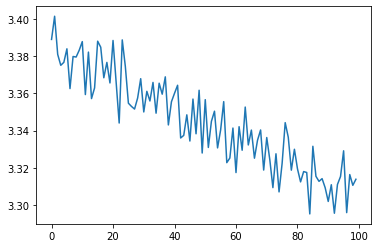

In [117]:
plt.plot(range(epochs),losses)

In [118]:
with torch.no_grad():
    
    y_val = model(cat_test, con_test)
    
    loss = torch.sqrt(criterion(y_val,y_test))

In [119]:
loss

tensor(3.2560)

In [120]:
total = 0
for  i in range (10):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    total = total + diff
    print(f'{i}.) PREDICTED: {y_val[i].item(): 8.2f}       true: {y_test[i].item():8.2f}        DIFF:  {diff:8.2f}')
    
print(total * 1.0 / 10.0)    

0.) PREDICTED:     3.69       true:     2.90        DIFF:      0.79
1.) PREDICTED:    22.87       true:     5.70        DIFF:     17.17
2.) PREDICTED:     7.56       true:     7.70        DIFF:      0.14
3.) PREDICTED:     9.45       true:    12.50        DIFF:      3.05
4.) PREDICTED:     5.38       true:     4.10        DIFF:      1.28
5.) PREDICTED:     5.36       true:     5.30        DIFF:      0.06
6.) PREDICTED:     4.07       true:     3.70        DIFF:      0.37
7.) PREDICTED:    16.20       true:    14.50        DIFF:      1.70
8.) PREDICTED:     3.65       true:     5.70        DIFF:      2.05
9.) PREDICTED:    11.99       true:    10.10        DIFF:      1.89
2.8515109539031984


In [121]:
torch.save(model.state_dict(),'TaxiModel.pt')